# New Cs-137 notebook

May 2017
This notebook replaces the old one; this analysis uses the XAMSAnalysis class and has the correct gain set.


## Imports and settings

In [1]:
%run '../definitions.ipynb'
%run '../treemakers.ipynb'
%run '../Analysis_class.ipynb'

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# Toggle data location
local_data = False

In [3]:
if local_data:
    processed_data_path = '/home/erik/win/data/xams_run8/processed/low_pmt_gain/'
    minitree_path = '/home/erik/win/data/xams_run8/minitrees/'
else:
    # processed_data_path = '/data/xenon/xams/run8/processed/data/'
    # minitree_path = '/data/xenon/xams/run8/minitrees/'
    processed_data_path = '/data/xenon/xams/run8/processed_v2/'
    minitree_path = '/data/xenon/xams/run8/minitrees/'

In [4]:
run_names_cs = get_run_list(processed_data_path, '170323_152801', '170323_154257')

Run list contains 3 files


## Load data

In [5]:
x = XAMSAnalysis(run_names_cs, processed_data_path, minitree_path)

In [6]:
x.load()
x.add_livetime()

Loaded 125339 (125.3 k) events.


## Cuts

### At least one interaction

In [7]:
sum((x.d['s1'] > 40) | (x.d['largest_other_s1'] > 40))

123331

In [8]:
x.cut_interaction_exists()

Finite s1 selection: 9244 rows removed (92.62% passed)


In [9]:
plt.style.use('latex_prl')

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [10]:
def plt_savefig(filename, folder='plots'):
    plt.savefig(os.path.join(folder, filename + '.pdf'))

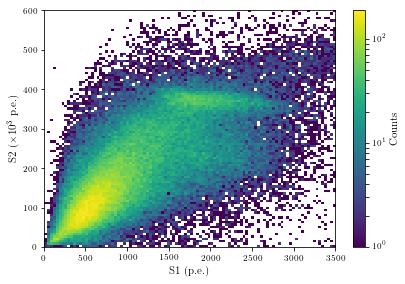

In [11]:
x.plot_s1s2(bins=100, norm=LogNorm(), range=((0, 3500), (0, 600e3)))
plt.colorbar(label='Counts')
plt_divide_axis('y', factor=1000)
plt.ylabel(r'S2 ($\times10^3$ p.e.)')
plt_savefig('cs_s1s2_uncut')

### Thresholds

Note that S2 classification is only > 8 p.e. and trigger requires some threshold as wel..

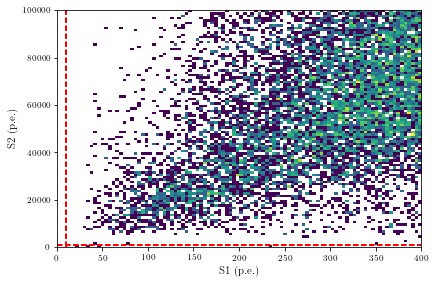

s1 above 10 selection: 0 rows removed (100.00% passed)
s2 above 1000 selection: 26 rows removed (99.98% passed)


In [12]:
x.cut_thresholds(s1_threshold=10, s2_threshold=1000,
    apply=True, plot=True, bins=100, norm=LogNorm(), range=((0, 400), (0, 100e3)))

### Single scatter S1

As shown in the figure below, a large fraction of the other S1s consist of misclassified single-e S2s or tails of the S2. We can keep these events at the risk of including true S1s that are quite small, or we throw them out. The acceptance is large anyway. 

largest_other_s1 below 40 selection: 2453 rows removed (97.89% passed)


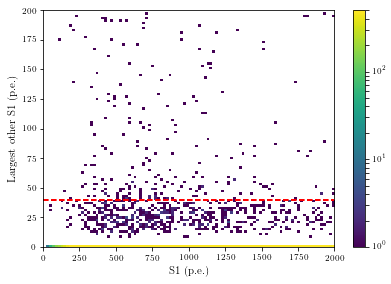

In [13]:
x.cut_largest_other_s1(largest_other_s1_max=40, plot=True, apply=True, bins=100, 
                       norm=LogNorm(), range=((0, 2000), (0, 200)), vmin=1, vmax=500)
plt.colorbar()
plt.show()

In [14]:
acc = 2324/ 115923 * 100
dacc = np.sqrt(2324) / 115923 * 100
print('%.3f +- %.3f' %(acc, dacc))

2.005 +- 0.042


In [15]:
x.livetime

900.83330347200013

In [16]:
run_time = x.livetime
# Number of events actually containing something of an S1
rate  = 123150 / run_time
event_length = 163.820 * 1e-6
# This is not a great calculation, it should actually be something Poissonian
print('Estimated pileup fraction: %.2f %%' % (rate * event_length * 100))
print('Rate: %.1f Hz' % (rate))

Estimated pileup fraction: 2.24 %
Rate: 136.7 Hz


### Single scatter S2

We want the second S2s to be consistent with single-electron pileup.

In [17]:
_d = x.d

In [18]:
_d = _d[(_d['largest_other_s2']) > 100]
_d['dz'] = 100 / 60 * 0.001 * abs(_d['largest_other_s2_center_time'] - _d['s2_center_time'])

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
def exp_decay(x, a0, tau):
    return a0 * np.exp(-x / tau)

In [20]:
counts, bin_edges = np.histogram(_d['dz'], bins=200, range=(0, 20))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
fit_range  = (4, 10)
x_fit = bin_centers[(bin_centers >= fit_range[0]) & (bin_centers < fit_range[1])]
y_fit = counts[(bin_centers >= fit_range[0]) & (bin_centers < fit_range[1])]
y_err = np.sqrt(y_fit)
popt_dz, pcov_dz = scipy.optimize.curve_fit(exp_decay, x_fit, y_fit, sigma = y_err, p0=[500, 10])


predicted_counts = [exp_decay(_x, *popt_dz) for _x in np.linspace(0, 10, 100)]
print('Predicted number of counts 0-10 mm: %d' % sum(predicted_counts))
actual_counts = sum(_d['dz'] < 10)
print('Actual number of counts 0-10 mm: %d' % actual_counts)

Predicted number of counts 0-10 mm: 28090
Actual number of counts 0-10 mm: 14509


In [21]:
popt_dz

array([ 628.7479747 ,    5.22584938])

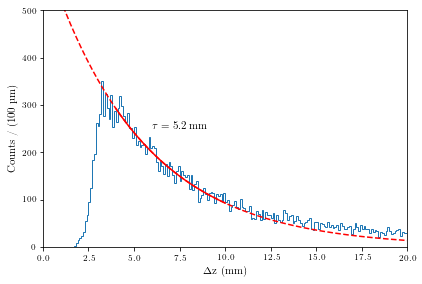

In [22]:
plt.hist(100 / 60 * 0.001 * abs(_d['largest_other_s2_center_time'] - _d['s2_center_time']), histtype='step', bins=200, 
         range=(0, 20))
x_fit_range = np.linspace(*fit_range, num = 50)
x_plot = np.linspace(0, 20, 200)
plt.plot(x_plot, exp_decay(x_plot, *popt_dz), ls='--', color='red')
plt.plot(x_fit_range, exp_decay(x_fit_range, *popt_dz), ls='solid', color='red')
plt.xlabel(r'$\Delta$z (\si{mm})')
plt.xlim(0, 20)
plt.ylabel(r'Counts / (\SI{100}{\micro m})')
plt.ylim(0, 500)
plt.text(6, 250, r'$\tau = $ \SI{5.2}{mm}')

plt_savefig('cs_s2_resolution')
plt.show()

largest_other_s2 below 100 selection: 23269 rows removed (79.52% passed)


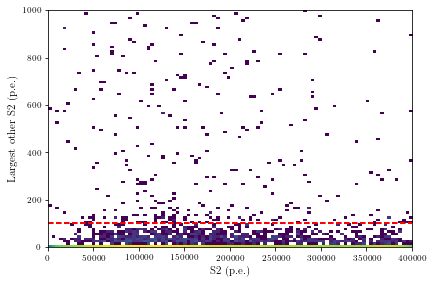

In [23]:
x.cut_largest_other_s2(largest_other_s2_max=100, 
                       plot=True, apply=True, bins=100, norm=LogNorm(), range=((0, 400e3), (0, 1000)))


This plot shows exactly what we expect for these events: a large peak at 0 from wrongly split S2s, a larger contribution after S2 and a neat spike at the cathode mesh location!

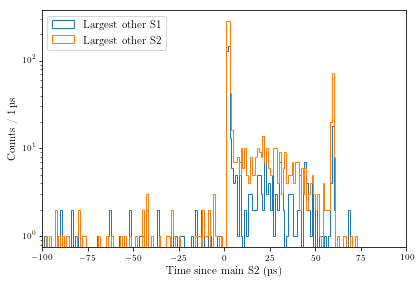

0.00555635494261
0.0120092532126


In [24]:
_d = x.d
plt.hist((_d['largest_other_s1_center_time'] - _d['s2_center_time'])*1e-3, 
         bins=200, histtype='step', range=(-100, 100), label='Largest other S1')
plt.hist((_d['largest_other_s2_center_time'] - _d['s2_center_time'])*1e-3, 
         bins=200, histtype='step', range=(-100, 100), label='Largest other S2')
plt.xlabel(r'Time since main S2 (\si{\micro s})')
plt.ylabel(r'Counts / \SI{1}{\micro s}')
plt.yscale('log')
plt.xlim(-100, 100)
plt.legend(loc='upper left')
plt_savefig('cs_other_time_diff')
plt.show()

print(sum(_d['largest_other_s1'] > 0) / len(_d))
print(sum(_d['largest_other_s2'] > 0) / len(_d))

### Saturation (NOT APPLIED)

This is just a check that the photopeak is not saturated. Seems to be OK. Cut does not really have to be applied, will be applied in energy selection.

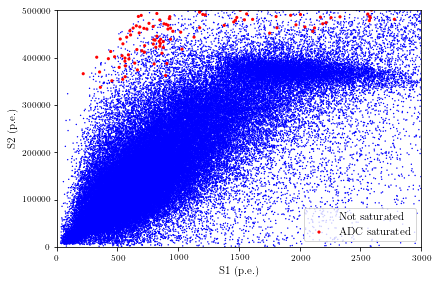

In [25]:
x.cut_saturation(apply=False, plot=True)
plt.xlim(0, 3000)
plt.ylim(0, 500e3)
plt.show()

### S1 AFT (NOT APPLIED)

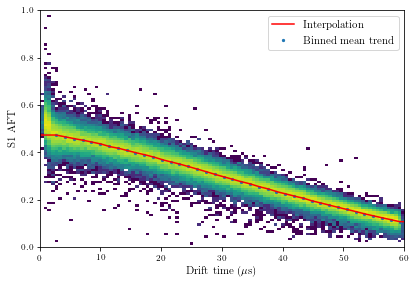

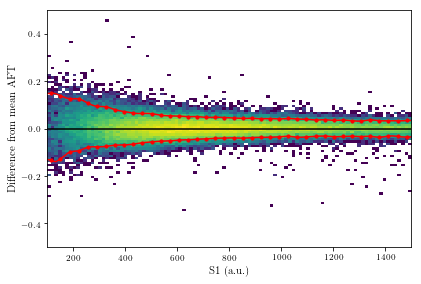

In [26]:
x.cut_s1_aft(plot=True, apply=False, s1_range=(100, 1500), s1_bins=40, dt_range=(2, 60), dt_bins=40)

### S2 AFT (NOT APPLIED)

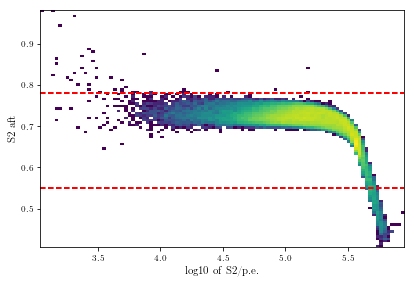

In [27]:
x.cut_s2_aft(apply=False, plot=True)

### S2 width

In [28]:
_d = x.d

In [29]:
def s2_width_model_t(t, diffusion_constant, w0):
        '''
        S2 width model stolen from Jelly Monster. Great info on wiki.
        Input drift time in us
        '''
        # diffusion_constant = PAX_CONFIG['WaveformSimulator']['diffusion_constant_liquid']
        v_drift = drift_velocity_liquid = 1.68 * 10**5 # cm/s
        t = t * 1e-6 # Convert to seconds
        # w0 = 348.6 * units.ns
        # WATCH the constant: it is NOT 4.something
        return 1e9 * np.sqrt(w0 ** 2 + 3.6395 * diffusion_constant * t / v_drift ** 2)

In [30]:
for nbins in [20, 30, 40, 50]:
    dt, s2_50 = get_trend(_d['drift_time'], _d['s2_range_50p_area'], (0, 60), bins=nbins, mode='median')
    dt_cutoff = 30 # us

    popt_s2_w, pcov_s2_w = scipy.optimize.curve_fit(s2_width_model_t, dt[dt >= dt_cutoff], s2_50[dt > dt_cutoff],
                                                    p0=[10, 250e-9])
    perr_s2_w = np.sqrt(np.diag(pcov_s2_w))
    print('Diffusion is %.2f +- %.2f cm**2 / s' % (popt_s2_w[0], perr_s2_w[0]))


Diffusion is 14.59 +- 0.32 cm**2 / s
Diffusion is 14.59 +- 0.39 cm**2 / s
Diffusion is 14.70 +- 0.29 cm**2 / s
Diffusion is 14.71 +- 0.35 cm**2 / s


In [31]:
for cutoff in [20, 25, 30, 35, 40]:
    nbins = 30
    dt_cutoff = cutoff 
    dt, s2_50 = get_trend(_d['drift_time'], _d['s2_range_50p_area'], (0, 60), bins=nbins, mode='median')

    popt_s2_w, pcov_s2_w = scipy.optimize.curve_fit(s2_width_model_t, dt[dt >= dt_cutoff], s2_50[dt >= dt_cutoff],
                                                    p0=[10, 250e-9])
    perr_s2_w = np.sqrt(np.diag(pcov_s2_w))
    print('Diffusion is %.2f +- %.2f cm**2 / s' % (popt_s2_w[0], perr_s2_w[0]))


Diffusion is 14.19 +- 0.31 cm**2 / s
Diffusion is 14.12 +- 0.31 cm**2 / s
Diffusion is 14.59 +- 0.39 cm**2 / s
Diffusion is 14.75 +- 0.51 cm**2 / s
Diffusion is 15.36 +- 0.84 cm**2 / s


In [32]:
# The Final Solution (too soon?)
nbins = 30
dt_cutoff = 30
syst_err = np.sqrt(0.1**2 + 0.4**2)

dt, s2_50 = get_trend(_d['drift_time'], _d['s2_range_50p_area'], (0, 60), bins=nbins, mode='median')

popt_s2_w, pcov_s2_w = scipy.optimize.curve_fit(s2_width_model_t, dt[dt >= dt_cutoff], s2_50[dt >= dt_cutoff],
                                                p0=[10, 250e-9])
perr_s2_w = np.sqrt(np.diag(pcov_s2_w))
print('Diffusion is %.2f +- %.2f +- %.2f cm**2 / s' % (popt_s2_w[0], perr_s2_w[0], syst_err))
total_err = np.sqrt(perr_s2_w[0]**2 + syst_err**2)
print('Diffusion is %.2f +- %.2f cm**2 / s' % (popt_s2_w[0], total_err))

Diffusion is 14.59 +- 0.39 +- 0.41 cm**2 / s
Diffusion is 14.59 +- 0.57 cm**2 / s


In [33]:
_d['s2_width_difference'] = _d['s2_range_50p_area'] - s2_width_model_t(_d['drift_time'], *popt_s2_w)

Cutoff at 251.5 ns


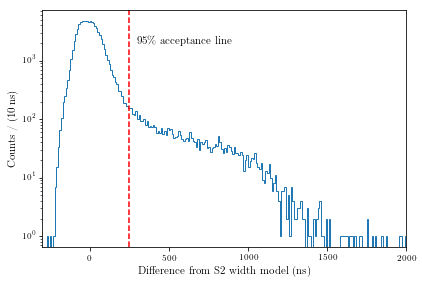

In [34]:
plt.hist(_d['s2_width_difference'], bins=230, histtype='step', range=(-300, 2000))
percentile_to_cut = 95
cutoff = np.percentile(_d['s2_width_difference'], percentile_to_cut)
print('Cutoff at %.1f ns' % cutoff)
plt.text(cutoff + 50, 2e3, (r'95\% acceptance line'))
plt.axvline(cutoff, ls='--', color='red')
plt.yscale('log')
plt.xlabel(r'Difference from S2 width model (\si{\nano s})')
plt.ylabel(r'Counts / (\SI{10}{ns})')
plt.xlim(-300, 2000)
plt_savefig('cs_s2_width_hist')
plt.show()

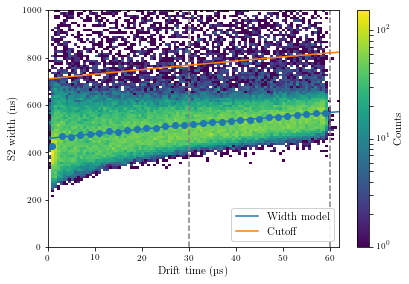

In [35]:
plt.hist2d(_d['drift_time'], _d['s2_range_50p_area'], bins=100, range=((0, 62), (0, 1e3)), norm=LogNorm())
plt.colorbar(label='Counts')
plt.xlabel(r'Drift time (\si{\micro s})')
plt.ylabel(r'S2 width (\si{\nano s})')
x_plot = np.linspace(0, 62, 100)
p0 = [10, 250e-9]
plt.plot(x_plot, s2_width_model_t(x_plot, *popt_s2_w), label='Width model')
plt.plot(x_plot, s2_width_model_t(x_plot, *popt_s2_w) + cutoff, label='Cutoff')
for _l in (30, 60):
    plt.axvline(_l, ls='--', color='gray')
plt.scatter(dt, s2_50)
plt.legend(framealpha=0.9, loc = 'lower right')
plt_savefig('cs_s2_width')
plt.show()

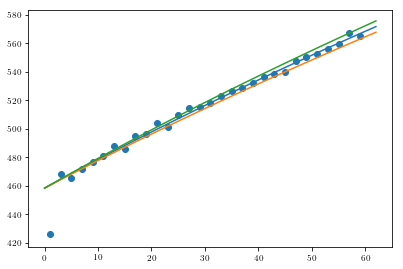

In [36]:
plt.plot(x_plot, s2_width_model_t(x_plot, *popt_s2_w), label='Width model')
for _pm in [-1, +1]:
    plt.plot(x_plot, s2_width_model_t(x_plot, popt_s2_w[0] + _pm * total_err, popt_s2_w[1]), label='+- 1 sigma')
plt.scatter(dt, s2_50, label='Medians')
plt.show()

#### Calculate resolution, contamination, and apply cut

In [37]:
# This is how many mm the 250 ns cutoff would correspond to in drift time
cutoff / (60e3) * 100 # mm
# Estimate factor of 2 difference? 1500 ns width versus 3 us cutoff (5 mm)

0.41920427712121733

In [38]:
_d = cuts.selection(_d, _d['s2_width_difference'] < cutoff, 'S2 width')

S2 width selection: 4518 rows removed (95.00% passed)


In [39]:
# Predicted counts 0-10 mm minus observed 0-10 mm minus number of rows cut
n_counts_left = sum(predicted_counts) - actual_counts - 4518

In [40]:
n_counts_left

9063.7271845490541

In [41]:
a0  = popt_dz[0]
tau = popt_dz[1]
bin_width = 0.1
a0*tau*(1 - np.exp(- 10./tau)) / bin_width

28009.194854960482

In [42]:
# ACTUAL ESTIMATED RESOLVING POWER S2S in mm
- tau * np.log(1 - n_counts_left * 0.1/(a0 * tau))

1.6866796355034879

In [43]:
# Apply cut by re-inserting the dataframe
x.d = _d

### Drift time

drift_time in [0, 62) selection: 3 rows removed (100.00% passed)


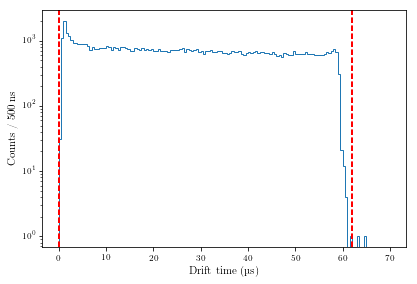

In [44]:
x.cut_drift_time(apply=True, plot=True, range=(0, 70), drift_time_bounds=(0, 62), bins=140, histtype='step')
plt.yscale('log')
plt.xlabel(r'Drift time (\si{\micro s})')
plt.ylabel(r'Counts / \SI{500}{\nano s}')

## Cut summary

In [45]:
asdf = x.cuts_history()

In [46]:
asdf['n_removed'] / asdf['n_before'] * 100

0     7.375198
1     0.000000
2     0.022395
3     2.113398
4    20.480390
5     5.000719
6     0.003495
dtype: float64

In [47]:
asdf

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,Finite s1,125339,116095,9244,0.926248,0.926248
1,s1 above 10,116095,116095,0,1.000000,0.926248
2,s2 above 1000,116095,116069,26,0.999776,0.926041
3,largest_other_s1 below 40,116069,113616,2453,0.978866,0.906470
4,largest_other_s2 below 100,113616,90347,23269,0.795196,0.720821
5,S2 width,90347,85829,4518,0.949993,0.684775
6,"drift_time in [0, 62)",85829,85826,3,0.999965,0.684751


In [48]:
n_counts_left / 85826

0.10560584420279466

In [49]:
85826 / 125339

0.6847509554089309

#### Build plots to check the S2 width dependence

In [50]:
remake_plots = False

In [51]:
if remake_plots:
    d = deepcopy(x.d)
    for pct in range(30):
        z, s2 = get_trend(d['z'], d['s2_range_50p_area'], x_range=(-10, 0), bins=20, mode='percentile', pct=pct)
        cut_line = my_interp(z, s2, kind='linear')
        x.d = x.d[x.d['s2_range_50p_area'] > cut_line(x.d['z'])]
        x.plot_cs1bs2(bins=100, norm=LogNorm(), range=((0, 3e3), (0, 150e3)), vmin=1, vmax=300)
        plt.colorbar()
        plt.savefig('cs1_%02d_pct_cut.png' % pct)
        plt.close()
    
    x.d = d
    for pct in np.arange(100, 70, -1):
        z, s2 = get_trend(d['z'], d['s2_range_50p_area'], x_range=(-10, 0), bins=20, mode='percentile', pct=pct)
        cut_line = my_interp(z, s2, kind='linear')
        x.d = x.d[x.d['s2_range_50p_area'] < cut_line(x.d['z'])]
        x.plot_cs1bs2(bins=100, norm=LogNorm(), range=((0, 3e3), (0, 150e3)), vmin=1, vmax=300)
        plt.colorbar()
        plt.savefig('cs1_%02d_pct_cut.png' % pct)
        plt.close()
        
    x.d = d
    for pct in np.arange(0, 50, 1):
        z, s2_low = get_trend(d['z'], d['s2_range_50p_area'], x_range=(-10, 0), bins=20, mode='percentile', pct=pct)
        z, s2_high = get_trend(d['z'], d['s2_range_50p_area'], x_range=(-10, 0), bins=20, mode='percentile', pct=(100-pct))
        cut_line_low = my_interp(z, s2_low, kind='linear')
        cut_line_high = my_interp(z, s2_high, kind='linear')
        x.d = x.d[(x.d['s2_range_50p_area'] < cut_line_high(x.d['z'])) & (x.d['s2_range_50p_area'] > cut_line_low(x.d['z']))]
        x.plot_cs1bs2(bins=100, norm=LogNorm(), range=((0, 3e3), (0, 150e3)), vmin=1, vmax=300)
        plt.colorbar()
        plt.savefig('cs1__dual_%02d_pct_cut.png' % pct)
        plt.close()
    # Restore copy
    x.d = d

## Corrections

### Compute S1 LY correction based on rough selection

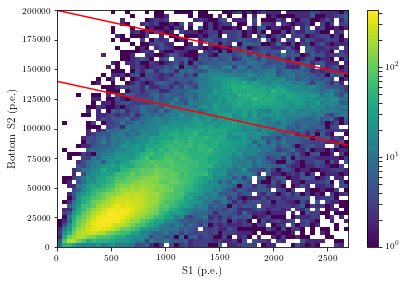

In [56]:
x.plot_s1bs2(bins=60, norm=LogNorm(), range=((0, 2700), (0, 200e3)))
x_plot = np.linspace(0, 3e3, 10)
def lower(s1):
    return 140e3 - 20*s1
def upper(s1):
    return 200e3 - 20 * s1

plt.plot(x_plot, upper(x_plot), color='red')
plt.plot(x_plot, lower(x_plot), color='red')
plt.colorbar()
plt.show()

In [57]:
d = x.d
# Select photopeak
d = d[(d['s2_bot'] < upper(d['s1'])) & (d['s2_bot'] > lower(d['s1']))]

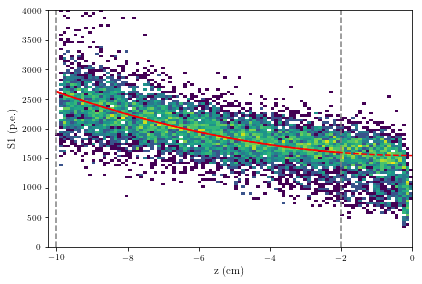

In [61]:
# Remnants from interpolation phase
# x1, y1 = get_trend(d['z'], d['s1'], x_range=(-10,0), bins=20, mode='mean')
# f = my_interp(x1,y1,kind='linear')
# plt.plot(x_plot, f(x_plot), color='red', label='Interpolation')
# plt.scatter(x1,y1, color='red')
# pickle.dump((x1,y1), open('cs137_ly.pickle', 'wb'))

sel = (d['z'] < -2) & (d['z'] > -10)
popt, pcov = scipy.optimize.curve_fit(p2, d['z'][sel], d['s1'][sel], p0=[500, 1, 10])

pickle.dump((p2, popt, pcov), open('data/cs137_ly_p2_rough.pickle', 'wb'))

plt.hist2d(d['z'], d['s1'], bins=100, norm=LogNorm(), range=((-10.25,0), (0,4000)))
x_plot = np.linspace(-10,0, 250)
x_fit_range = np.linspace(-10, -2, 200)
plt.plot(x_fit_range, p2(x_fit_range, *popt), label='Quadratic fit', color='red')
plt.plot(x_plot, p2(x_plot, *popt), label='Quadratic fit', color='red', ls='--')
for _l in (-10, -2):
    plt.axvline(_l, ls='--', color='gray')


plt.xlabel(r'z (\si{cm})')
plt.ylabel('S1 (p.e.)')
# plt.legend(loc='lower left')
plt.show()

### Apply S1 correction

In [62]:
x.corr_s1_ly_poly('data/cs137_ly_p2_rough.pickle')

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


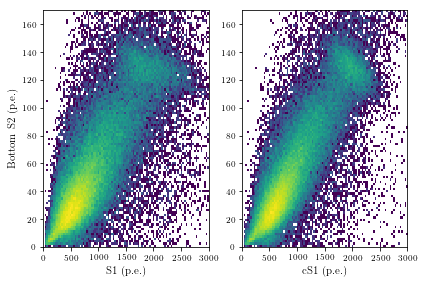

In [76]:
# plt.figure(figsize=(20,10))
plt.subplot(121)
x.plot_s1bs2(bins=100, range=((0,3000), (0, 170e3)), norm=LogNorm())
plt_divide_axis('y', 1000)
plt.subplot(122)
x.plot_cs1bs2(bins=100, range=((0,3000), (0, 170e3)), norm=LogNorm())
plt.ylabel('')
plt_divide_axis('y', 1000)

### S2 decrease

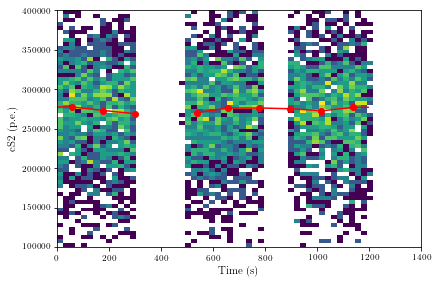

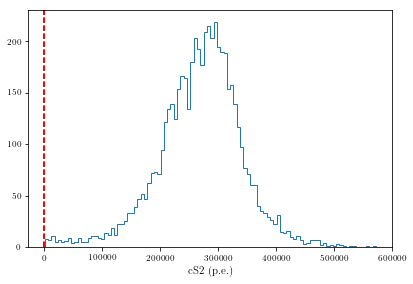

In [77]:
x.corr_s2_sag(plot=True, apply=False, cs1_range=(1200, 1400), cs2_cutoff=100, bins=60, norm=LogNorm(), 
              range=((0, 1400), (100e3, 400e3)))

## Result

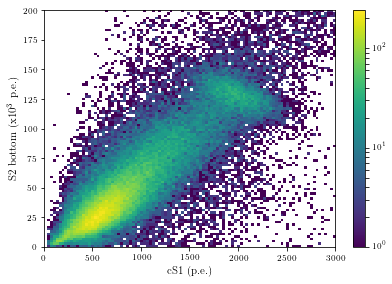

In [82]:
x.plot_cs1bs2(bins=100, norm=LogNorm(), range=((0, 3e3), (0, 200e3)))
plt_divide_axis(axis = 'y', factor=1000)
plt.ylabel('S2 bottom (x10$^3$ p.e.)')
plt.colorbar()
plt.show()

## Fit

### Photopeak selection

In [89]:
cs1_range = (1400, 2500)
cs2_range = (100e3, 160e3)
cs1_bins = 40
cs2_bins = 40

In [95]:
def cut1(x):
    return 185e3 - 40*x   
def cut2(x):
    return 230e3 - 40*x  

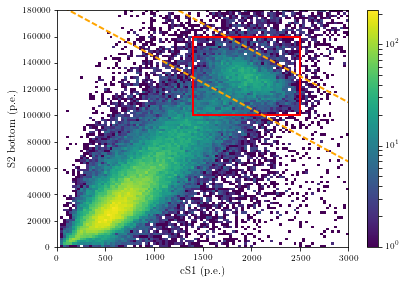

In [96]:
x.plot_cs1bs2(bins=100, norm=LogNorm(), range=((0, 3000), (0, 180e3)))
plt.colorbar()
draw_box(cs1_range, cs2_range, edgecolor='red', lw=2)
x_plot = np.linspace(0, 3000, 20)
plt.plot(x_plot, cut1(x_plot), color='orange', lw=2, ls='--')
plt.plot(x_plot, cut2(x_plot), color='orange', lw=2, ls='--')

### Binned fit

In [97]:
d = x.d

In [98]:
counts, x_fit, y_fit = build_fit_lists(d['cs1'], d['s2_bot'], cs1_range, cs2_range, cs1_bins, cs2_bins)

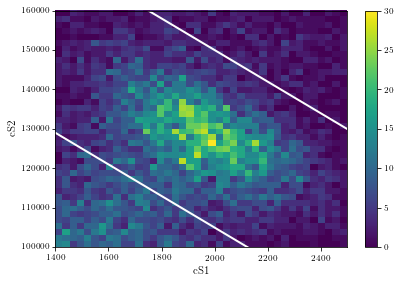

In [99]:
plt.hist2d(d['cs1'], d['s2_bot'], bins=(cs1_bins, cs2_bins), range=(cs1_range, cs2_range))#, norm=LogNorm())

x_plot = np.linspace(*cs1_range, num=20)
for cut in [cut1, cut2]:
    plt.plot(x_plot, cut(x_plot), color='white', lw=2)
plt.colorbar()
plt.xlabel('cS1')
plt.ylabel('cS2')
plt.show()

In [100]:
sel = (cut1(x_fit) < y_fit) & (cut2(x_fit) > y_fit)

In [102]:
initial_guess = (30,2000,130000,30,2000,-0.03,0)
popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x_fit[sel], y_fit[sel]), counts[sel], p0=initial_guess)
print('cS1 peak position: %.1f' % (popt[1]))
print('cS2 peak position: %.1f' % (popt[2]))
print(popt)
theta = popt[-2]
slope = np.tan(theta)
pickle.dump()

cS1 peak position: 1949.6
cS2 peak position: 128146.5
[  2.02238548e+01   1.94962709e+03   1.28146518e+05   1.97880660e+02
   1.07449588e+04  -9.21035190e-03   1.06193606e+00]


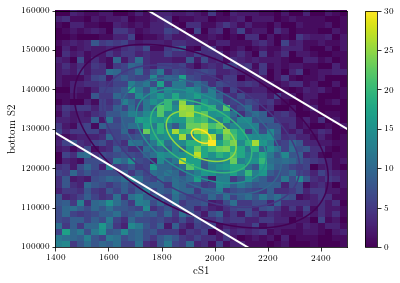

In [103]:
plt.hist2d(d['cs1'], d['s2_bot'], bins=(cs1_bins, cs2_bins), range=(cs1_range, cs2_range))#, norm=LogNorm())

x_plot = np.linspace(*cs1_range, num=20)
for cut in [cut1, cut2]:
    plt.plot(x_plot, cut(x_plot), color='white', lw=2)
plt.colorbar()

plot2d(twoD_Gaussian, popt, cs1_range, cs2_range, 10, 100)

plt.xlabel('cS1')
plt.ylabel('bottom S2')
plt.savefig('plots/cs_photopeak_fit.png')
plt.show()

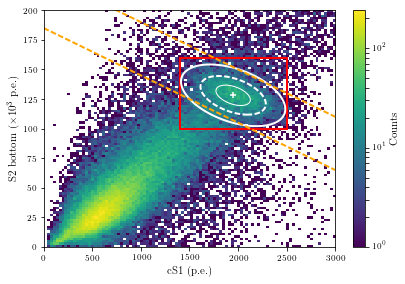

In [115]:
x.plot_cs1bs2(bins=100, norm=LogNorm(), range=((0, 3000), (0, 200e3)))
plt.colorbar(label='Counts')
draw_box(cs1_range, cs2_range, edgecolor='red', lw=2)
x_plot = np.linspace(0, 3000, 20)
plt.plot(x_plot, cut1(x_plot), color='orange', lw=2, ls='--')
plt.plot(x_plot, cut2(x_plot), color='orange', lw=2, ls='--')
# Draw contours at 0.5, 1 and 1.5 sigma
gaus_max = popt[0]
sigma_levels = [gaus(1.5, gaus_max, 0, 1), gaus(1, gaus_max, 0, 1), gaus(0.5, gaus_max, 0, 1)]
plot2d(twoD_Gaussian, popt, (1400, 2600), cs2_range, 4, 40, levels=sigma_levels, 
       colors=['white', 'white', 'white'],
       linewidths = [2,2,1],
       linestyles = ['solid', 'dashed', 'solid'],
      )
plt_divide_axis('y', 1000)
plt.ylabel(r'S2 bottom ($\times 10^3$ p.e.)')
plt.scatter(popt[1], popt[2], marker = '+', color='white')

In [116]:
pickle.dump((popt, pcov), open('data/cs137_s1s2fit_2d_rough.pickle', 'wb'))

### Try fit with ne and ngamma

In [46]:
d = x.d
g1 = 0.07099636
g2 = 3.08170177
d['n_e'] = d['s2_bot'] / g2
d['n_g'] = d['cs1'] / g1

def twoD_gaussian_ne_ng(n_tuple, A, n_quanta, f_g_expected, sigma_n_g, sigma_n_e, sigma_f_g, offset):
    n_g = n_tuple[0]
    n_e = n_tuple[1]
    # Assuming a fixed number of quanta

    # Calculate where on the diagonal line you are, based on the actual data!
    f_g = n_g / (n_g + n_e)
    
    # f_g is the gamma fraction
    n_g_expected = n_quanta * f_g
    n_e_expected = n_quanta * (1 - f_g)
    
    def gauss(x, mu, sigma):
        return np.exp(- (x-mu)**2/(2 * sigma**2))
    
    return (A *
            gauss(f_g, f_g_expected, sigma_f_g) *
            gauss(n_g, n_g_expected, sigma_n_g) *
            gauss(n_e, n_e_expected, sigma_n_e) + offset
           )
    
    

In [47]:
n_g_range = (15000, 26000)
n_e_range = (23e3, 35e3)
n_g_bins = 40
n_e_bins = 40

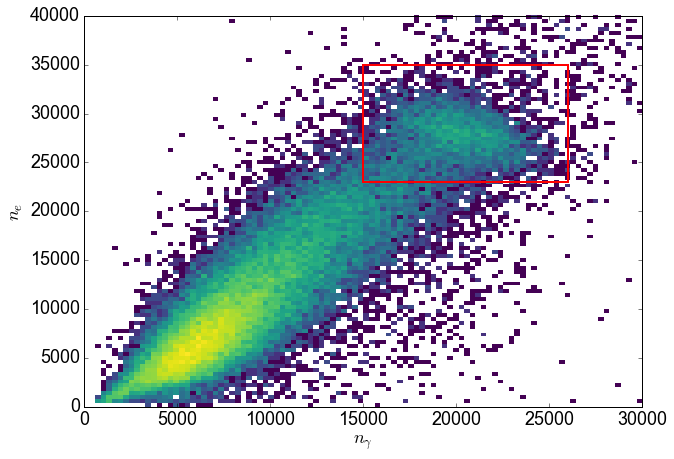

In [48]:
plt.hist2d(d['n_g'], d['n_e'], bins=100, norm=LogNorm(), range=((0, 30000), (0, 40e3)))
draw_box(n_g_range, n_e_range, edgecolor='red', lw=2)
plt.xlabel('$n_{\gamma}$')
plt.ylabel('$n_{e}$')
plt.show()

In [49]:
counts, x_fit, y_fit = build_fit_lists(d['n_g'], d['n_e'], n_g_range, n_e_range, n_g_bins, n_e_bins)

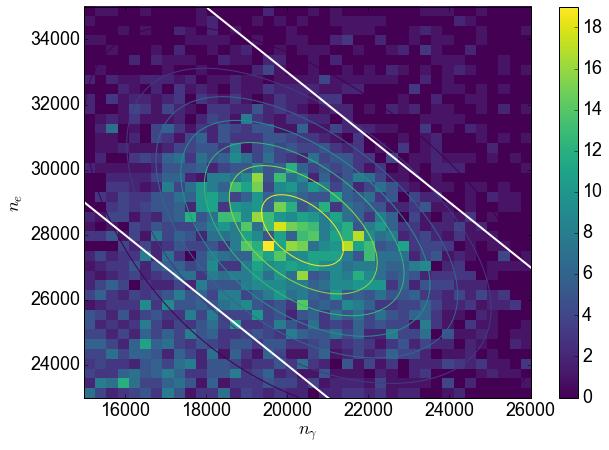

In [50]:
def cut_high(n_g):
    return 53e3 - 1.0 * n_g
def cut_low(n_g):
    return 44e3 - 1.0 * n_g
    
x_plot = np.linspace(0, 30e3)

plt.hist2d(d['n_g'], d['n_e'], range=(n_g_range, n_e_range), bins=(n_g_bins, n_e_bins))
plt.colorbar()
x_plot = np.linspace(*n_g_range)
plt.plot(x_plot, cut_high(x_plot), color='white', lw=2)
plt.plot(x_plot, cut_low(x_plot), color='white', lw=2)
plt.xlabel('$n_{\gamma}$')
plt.ylabel('$n_{e}$')

# A, n_quanta, f_g_expected, sigma_n_g, sigma_n_e, sigma_f_g, offset
guess_g_e = [22, 48.5e3, 0.42, 2000, 2000, 0.05, 0.5]
# plot2d(twoD_gaussian_ne_ng, popt_g_e, n_g_range, n_e_range, 100, 100)
plot2d(twoD_gaussian_ne_ng, guess_g_e, n_g_range, n_e_range, 100, 100)

# plt.plot(x_plot, (1 - popt_g_e[2])/(popt_g_e[2])* x_plot)
# plt.plot(x_plot, popt_g_e[1] -  x_plot)

# x_center = popt_g_e[2] * popt_g_e[1]
# y_center = (1 - popt_g_e[2]) * popt_g_e[1]

# plt.arrow(x_center, y_center, dx = popt_g_e[3], dy=0)
# plt.arrow(x_center, y_center, dy = popt_g_e[4], dx=0)
# plt.arrow(x_center, y_center, dx = popt_g_e[5] * popt_g_e[1], dy = - popt_g_e[5] * popt_g_e[1])

plt.show()

sel = (y_fit < cut_high(x_fit)) & (y_fit > cut_low(x_fit))


In [51]:
popt_g_e, pcov_g_e = scipy.optimize.curve_fit(twoD_gaussian_ne_ng, (x_fit[sel], y_fit[sel]), counts[sel], p0 = guess_g_e)

In [52]:
popt_g_e

array([  1.11567151e+01,   4.78659255e+04,   4.18266018e-01,
         2.55896740e+03,   1.59982510e+03,   3.76871329e-02,
         2.68133199e-01])

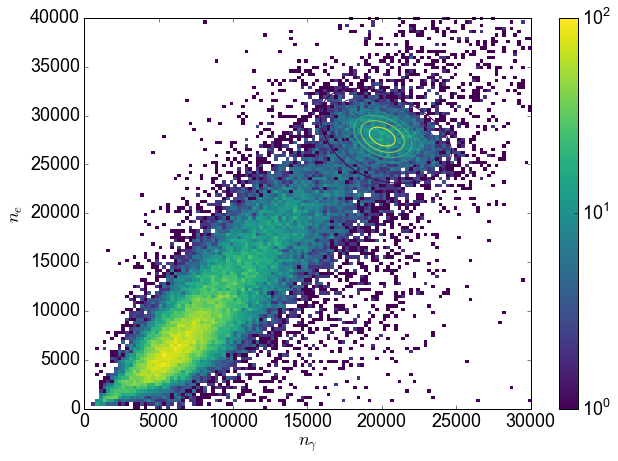

In [53]:
plt.hist2d(d['n_g'], d['n_e'], range=((0, 30e3), (0, 40e3)), bins=(120, 120), norm=LogNorm())
plt.colorbar()
plt.xlabel('$n_{\gamma}$')
plt.ylabel('$n_{e}$')

# A, n_quanta, f_g_expected, sigma_n_g, sigma_n_e, sigma_f_g, offset
# guess_g_e = [22, 48.5e3, 0.42, 2000, 2000, 0.05, 0.5]
plot2d(twoD_gaussian_ne_ng, popt_g_e, n_g_range, n_e_range, 100, 100)
# plot2d(twoD_gaussian_ne_ng, guess_g_e, n_g_range, n_e_range, 100, 100)

plt.show()

sel = (y_fit < cut_high(x_fit)) & (y_fit > cut_low(x_fit))


In [54]:
popt_g_e

array([  1.11567151e+01,   4.78659255e+04,   4.18266018e-01,
         2.55896740e+03,   1.59982510e+03,   3.76871329e-02,
         2.68133199e-01])

In [56]:
print('Pending...')

Pending...


## Energy

In [57]:
x.add_ces()
x.add_e_s1()
x.add_e_s2()

In [58]:
d = x.d

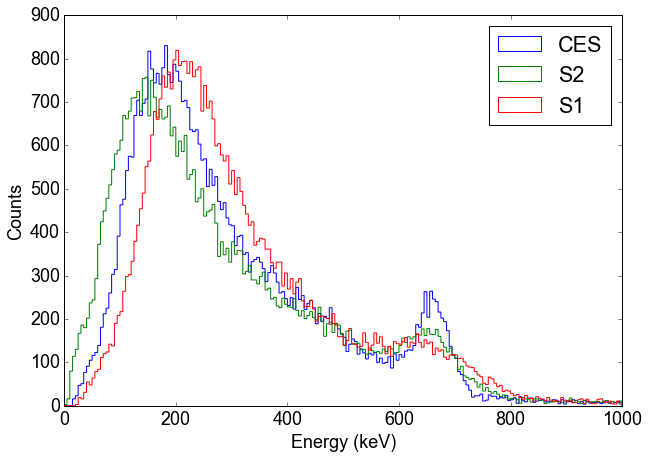

In [59]:
plt.hist(d['e_ces'], bins=200, histtype='step', range=(0, 1e3), label='CES')
plt.hist(d['e_s2'], bins=200, histtype='step', range=(0, 1e3), label='S2')
plt.hist(d['e_s1'], bins=200, histtype='step', range=(0, 1e3), label='S1')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.savefig('plots/cs_energy_scales.png')
plt.show()

### Unbinned fit

-237.039392334


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter a0 is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter off is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter slope is floating but does not 

FCN = -253.33573506057155 
 TOTAL NCALL = 192 
 NCALLS = 192 
 
 
 EDM = 1.1849020301664948e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a0,141.682,61.5373,0,0,,,
2,mu,661.981,1.82418,0,0,,,
3,sigma,34.691,3.65568,0,0,,,
4,off,295.034,100.361,0,0,,,
5,slope,-0.354842,0.121185,0,0,,,


0.05240491235101728


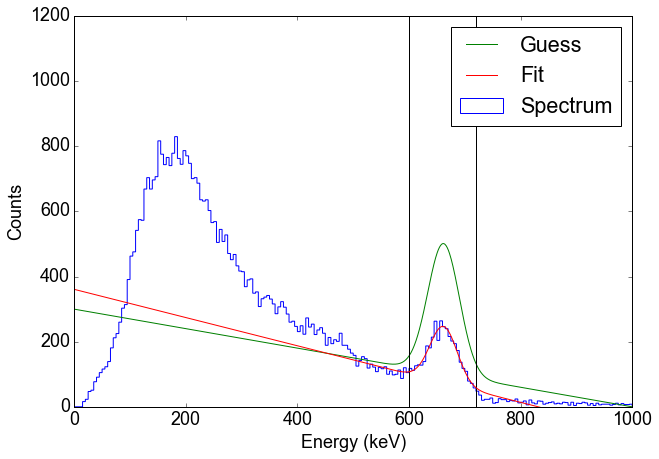

In [60]:
popt, m, norm = fit_gaus_with_bg(d['e_ces'].values, (600, 720), 400,  662, 40, 300, -0.3)
plt.ylim(0, 1200)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.savefig('plots/cs_ces.png')
plt.show()

-592.398335638


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter a0 is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter off is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter slope is floating but does not 

FCN = -640.7642613417315 
 TOTAL NCALL = 111 
 NCALLS = 111 
 
 
 EDM = 1800.2745343138818 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a0,75.0859,nan,0,0,,,
2,mu,662.812,1.34995,0,0,,,
3,sigma,103.517,4.03422,0,0,,,
4,off,247.263,3.68076,0,0,,,
5,slope,-0.301684,0.00475143,0,0,,,


0.15617906490441225


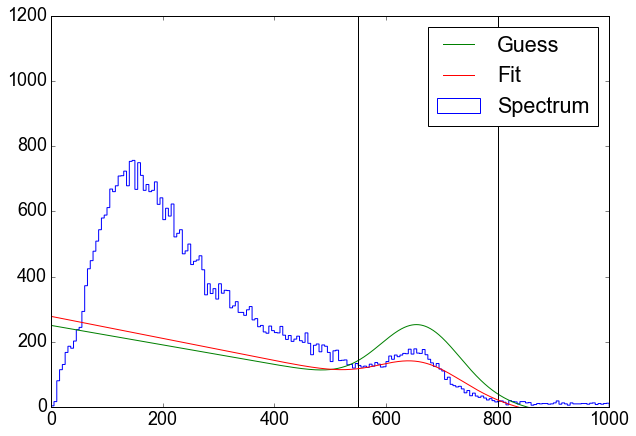

In [61]:
fit_gaus_with_bg(d['e_s2'], (550, 800), 200, 662, 100, 250, -0.3)
plt.ylim(0, 1200)
plt.show()

-353.602163223


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter a0 is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter off is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter slope is floating but does not 

FCN = -358.8004162538088 
 TOTAL NCALL = 168 
 NCALLS = 168 
 
 
 EDM = 0.00011201022730419183 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a0,36.0466,16.5392,0,0,,,
2,mu,660.353,12.1616,0,0,,,
3,sigma,85.3588,24.0329,0,0,,,
4,off,255.776,42.7971,0,0,,,
5,slope,-0.293361,0.0490982,0,0,,,


0.1292623853732088


(0, 1200)

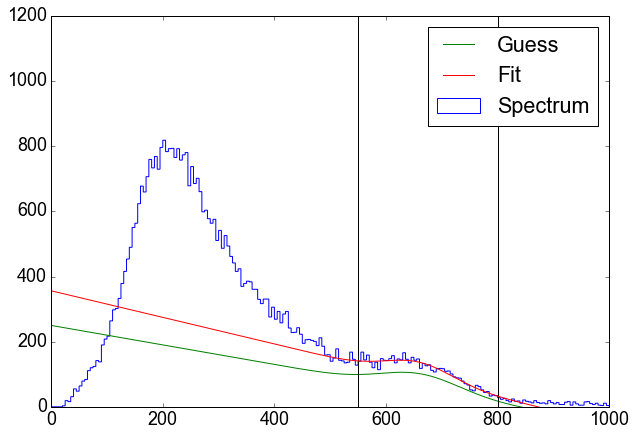

In [62]:
fit_gaus_with_bg(d['e_s1'], (550, 800), 50, 662, 100, 250, -0.3)
plt.ylim(0, 1200)

## Photopeak selection

In [63]:
sigmas_to_select = 2

energy_range = (m.values['mu'] - sigmas_to_select * m.values['sigma'], 
                m.values['mu'] + sigmas_to_select * m.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)

e_ces in [592.5985888768582, 731.3627440982514) selection: 42643 rows removed (8.87% passed)


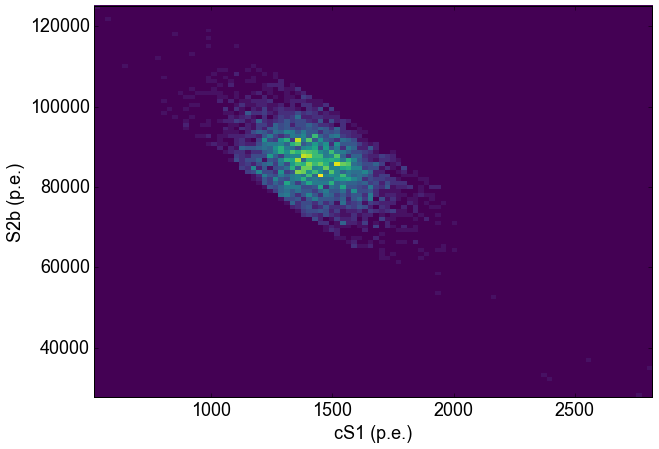

In [64]:
plt.hist2d(pp['cs1'], pp['s2_bot'], bins=100)
plt.xlabel('cS1 (p.e.)')
plt.ylabel('S2b (p.e.)')
plt.savefig('plots/cs_selection.png')
plt.show()

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.


FCN = -1713.213677782446 
 TOTAL NCALL = 62 
 NCALLS = 62 
 
 
 EDM = 4.042118460350002e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,1426.85,3.68061,0,0,,,
2,sigma,230.875,3.92883,0,0,,,


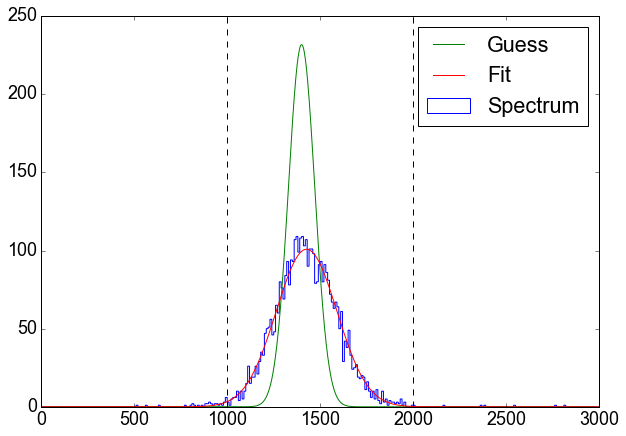

In [65]:
popt_cs1_it0, _ , _ =  fit_gaus(pp['cs1'], (1000, 2000), 1400, 100, (0, 3000), 300)

In [66]:
popt_cs1_it0

[1426.8486545883688, 230.8750513449378]

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.


FCN = -136.54691424632023 
 TOTAL NCALL = 29 
 NCALLS = 29 
 
 
 EDM = 7.355050049948419e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,1421.47,5.45085,0,0,,,
2,sigma,230.075,10.3273,0,0,,,


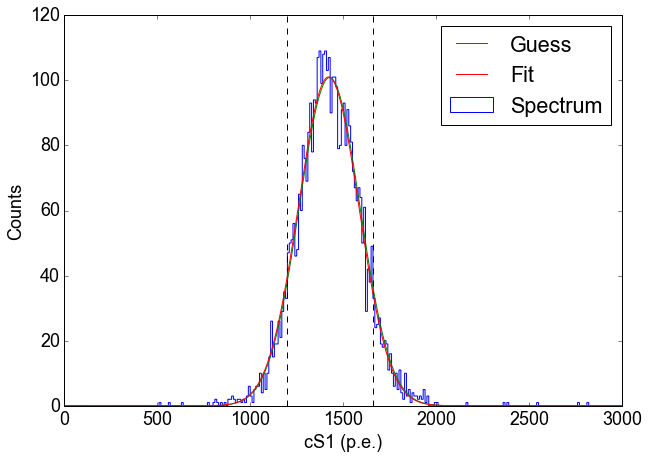

In [67]:
sigmas_to_select_cs1 = 1
popt_cs1_it1, m_cs1_it1 , _ =  fit_gaus(pp['cs1'], (popt_cs1_it0[0] - sigmas_to_select_cs1 * popt_cs1_it0[1], 
                                     popt_cs1_it0[0] + sigmas_to_select_cs1 * popt_cs1_it0[1])
                         , popt_cs1_it0[0], popt_cs1_it0[1], (0, 3000), 300)
plt.xlabel('cS1 (p.e.)')
plt.ylabel('Counts')
plt.savefig('plots/cs_s1_fit.png')

In [68]:
m_cs1_it1.errors

{'mu': 5.4508465472701175, 'sigma': 10.327316357925795}

In [69]:
m_cs1_it1.values

{'mu': 1421.4658667104945, 'sigma': 230.0749722708088}

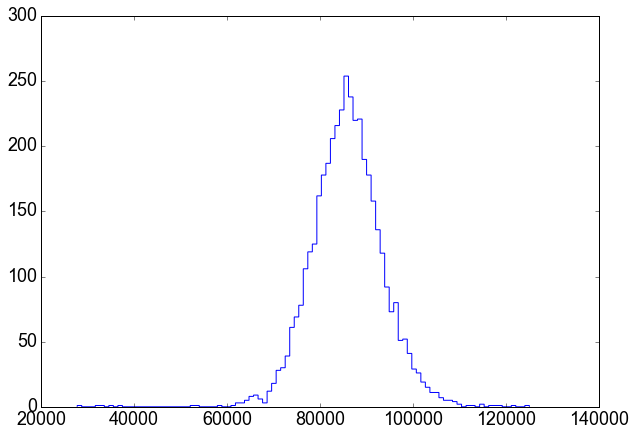

In [70]:
plt.hist(pp['s2_bot'], bins=100, histtype='step')
plt.show()

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.


FCN = -1102.024720291461 
 TOTAL NCALL = 57 
 NCALLS = 57 
 
 
 EDM = 5.543881911699671e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,85658.2,168.87,0,0,,,
2,sigma,9837.39,195.663,0,0,,,


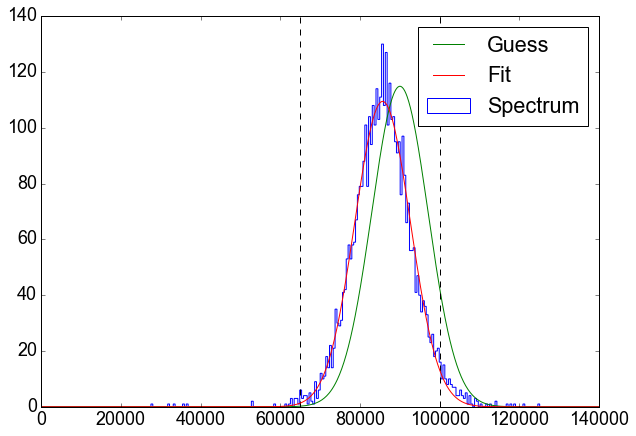

In [71]:
popt_cs2_it0, m_cs2_it0, _ = fit_gaus(pp['s2_bot'], (65e3, 100e3), 90e3, 10e3, (0, 140e3), 300, 1.)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.


FCN = -157.39592255708996 
 TOTAL NCALL = 33 
 NCALLS = 33 
 
 
 EDM = 1.5317979110191963e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,85558.9,216.54,0,0,,,
2,sigma,9364.46,392.834,0,0,,,


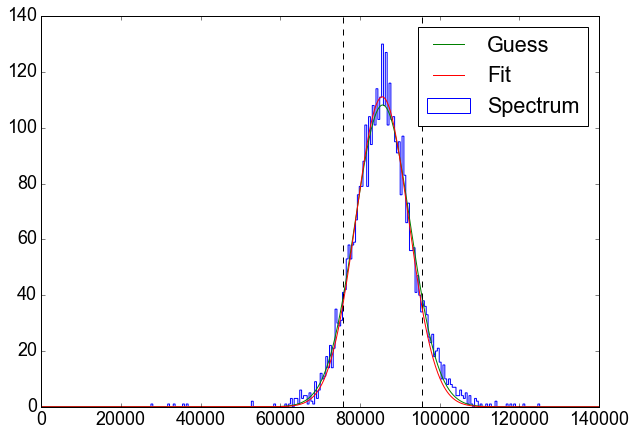

In [72]:
sigmas_to_select_cs2 = 1

popt_cs2_it1, m_cs2_it1, _ = fit_gaus(pp['s2_bot'], (popt_cs2_it0[0] - sigmas_to_select_cs2 * popt_cs2_it0[1],
                                                     popt_cs2_it0[0] + sigmas_to_select_cs2 * popt_cs2_it0[1]),
                                                     popt_cs2_it0[0], popt_cs2_it0[1], (0, 140e3), 300, 1.)

In [73]:
m_cs2_it1.values

{'mu': 85558.90385309825, 'sigma': 9364.457672525024}

In [74]:
m_cs2_it1.errors

{'mu': 216.54031890713074, 'sigma': 392.8341645402333}

### Updated g1, g2 values

In [75]:
x.add_ces(0.07633822,  2.91338611)
x.add_g1g2_props(g1 = 0.07099636,  g2 = 3.08170177)

In [76]:
d = x.d

-232.24687743


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter a0 is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter off is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter slope is floating but does not 

FCN = -240.79718185180576 
 TOTAL NCALL = 198 
 NCALLS = 198 
 
 
 EDM = 6.204769814650682e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a0,203.536,101.029,0,0,,,
2,mu,664.268,1.82802,0,0,,,
3,sigma,34.5771,3.73583,0,0,,,
4,off,387.798,156.214,0,0,,,
5,slope,-0.454195,0.183619,0,0,,,


0.05205292591126668


(0, 1200)

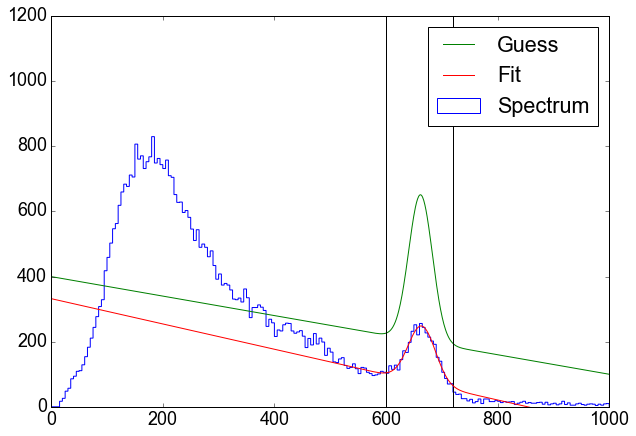

In [77]:
popt_ces, m_ces, _ = fit_gaus_with_bg(d['e_ces'], (600, 720), 450, 662, 30, 400, -0.3)
plt.xlim(0, 1000)
plt.ylim(0, 1200)

In [78]:
pp = cuts.range_selection(d, 'e_ces', (m_ces.values['mu'] - 2* m_ces.values['sigma'],
                                       m_ces.values['mu'] + 2* m_ces.values['sigma'])                                      
                                      )

e_ces in [595.1141272388644, 733.4225719895336) selection: 42649 rows removed (8.86% passed)


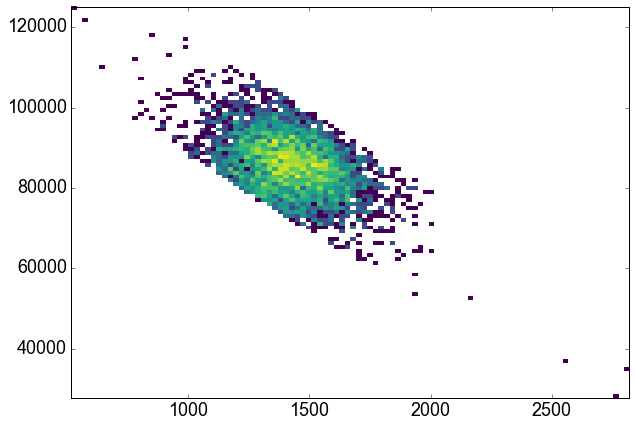

In [79]:
plt.hist2d(pp['cs1'], pp['s2_bot'], bins=100, norm=LogNorm())
plt.show()

In [80]:
pp.keys()

Index(['run_number', 'event_number', 'largest_other_s1_area',
       'largest_other_s1_area_fraction_top', 'largest_other_s1_center_time',
       'largest_other_s2_area', 'largest_other_s2_area_fraction_top',
       'largest_other_s2_center_time', 's1_center_time', 's1_left',
       's1_n_saturated_channels', 's2_center_time', 's2_left',
       's2_n_saturated_channels', 'cs1', 'cs2', 'drift_time',
       'largest_coincidence', 'largest_other_s1', 'largest_other_s2',
       'largest_unknown', 'largest_veto', 's1', 's1_area_fraction_top',
       's1_range_50p_area', 's2', 's2_area_fraction_top', 's2_range_50p_area',
       'x', 'y', 'z', 'event_duration', 'event_time', 't', 's1_top', 's1_bot',
       's1area_fraction_top', 's2_top', 's2_bot', 's2area_fraction_top',
       'largest_other_s1_top', 'largest_other_s1_bot',
       'largest_other_s1area_fraction_top', 'largest_other_s2_top',
       'largest_other_s2_bot', 'largest_other_s2area_fraction_top',
       's1_aft_difference', 'AFT_U

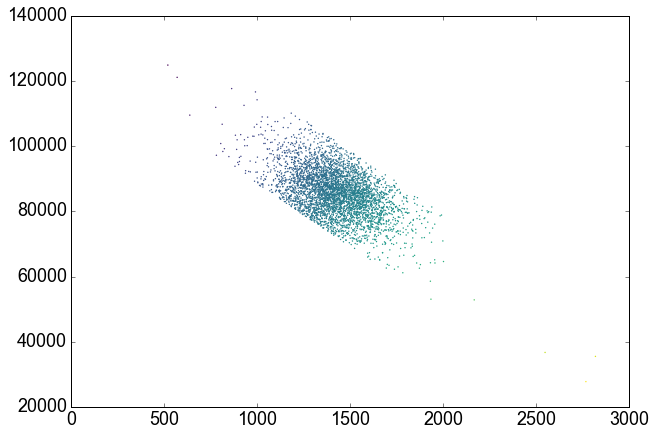

In [81]:
plt.scatter(pp['cs1'], pp['s2_bot'], edgecolor='None', s=2, c=pp['f_g'])
plt.show()

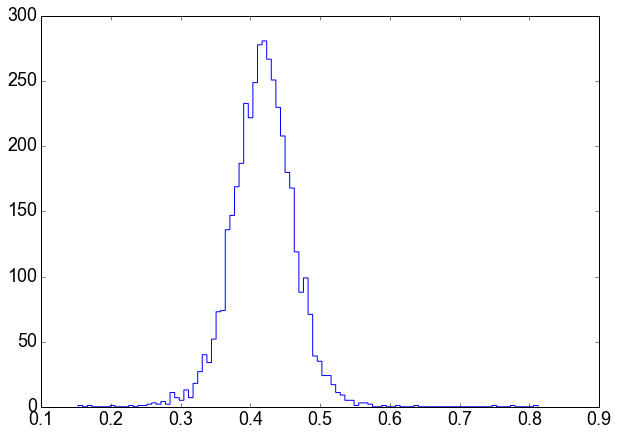

In [82]:
plt.hist(pp['f_g'], bins=100, histtype='step')
plt.show()

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.


FCN = -1052.1231560656079 
 TOTAL NCALL = 43 
 NCALLS = 43 
 
 
 EDM = 2.0566537432019548e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,0.418153,0.000997283,0,0,,,
2,sigma,0.0573979,0.00116637,0,0,,,


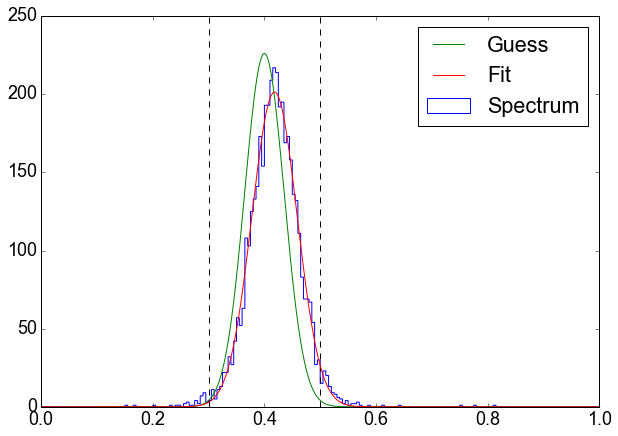

In [83]:
popt_f_g, m_f_g, _ = fit_gaus(pp['f_g'], (0.3, 0.5), 0.4, 0.05, plot_range=(0,1), plot_bins=200, int_step=0.001)

In [84]:
popt_f_g

[0.41815305234066424, 0.057397939877394]

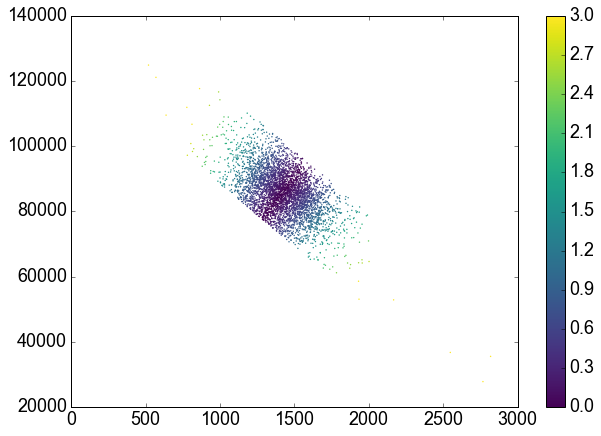

In [85]:
plt.scatter(pp['cs1'], pp['s2_bot'], edgecolor='None', s=2, c=abs(pp['f_g'] - popt_f_g[0])/popt_f_g[1], vmin=0, vmax=3)
plt.colorbar()
plt.show()

In [86]:
sigmas_to_select_f_g = 2

In [87]:
pp = cuts.range_selection(pp, 'f_g', (popt_f_g[0] - sigmas_to_select_f_g * popt_f_g[1],
                                     popt_f_g[0] + sigmas_to_select_f_g * popt_f_g[1]))

f_g in [0.30335717258587624, 0.5329489320954522) selection: 69 rows removed (98.34% passed)


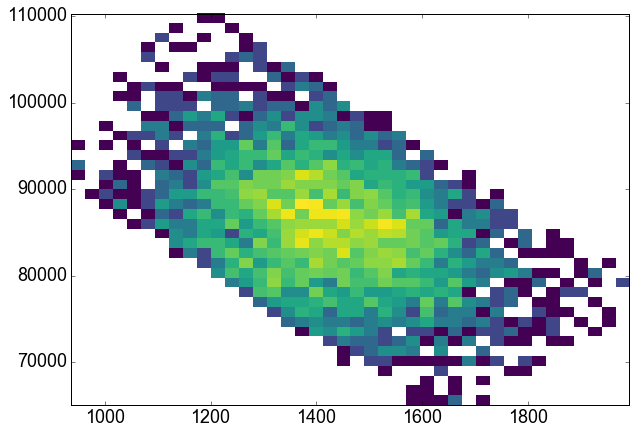

In [88]:
plt.hist2d(pp['cs1'], pp['s2_bot'], bins=40, norm=LogNorm())
plt.show()

In [89]:
_, popt_na, pcov_na = pickle.load(open('na22_ly_poly.pickle', 'rb'))
_, popt_cs, pcov_cs = pickle.load(open('cs137_ly_poly.pickle', 'rb'))

In [90]:
def p3(x, a0, a1, a2, a3):
    return a0 + a1 * x + a2 * x**2 + a3 * x**3

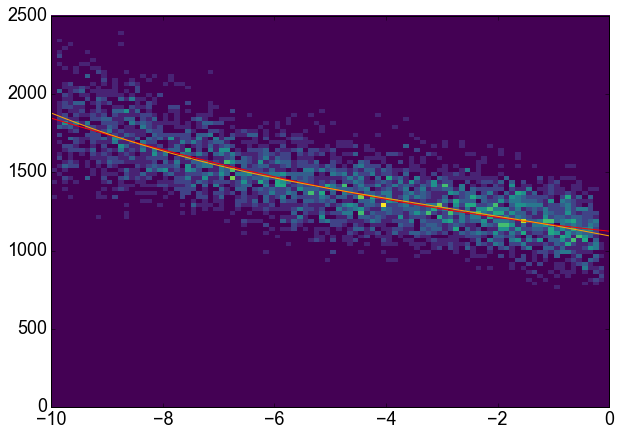

In [91]:
plt.hist2d(pp['z'], pp['s1'], bins=100, range=((-10, 0), (0,2500)))
guess = [1000, -50, 0.5]
guess3 = [1000, -50, 0.5, 0.1]
x_plot=  np.linspace(-10, 0, 200)
# plt.plot(x_plot, p2(x_plot, *guess))

popt_ly, pcov_ly = scipy.optimize.curve_fit(p2, pp['z'], pp['s1'], p0 = guess)
popt_ly3, pcov_ly3 = scipy.optimize.curve_fit(p3, pp['z'], pp['s1'], p0 = guess3)

plt.plot(x_plot, p2(x_plot, *popt_ly), color='red')
plt.plot(x_plot, p3(x_plot, *popt_ly3), color='orange')

plt.show()

In [92]:
def get_cs1(s1, z, f_s1_corr):
    average_s1 = np.average([f_s1_corr(_z) for _z in np.linspace(-10, 0, 500)])
    return s1/f_s1_corr(z) * average_s1

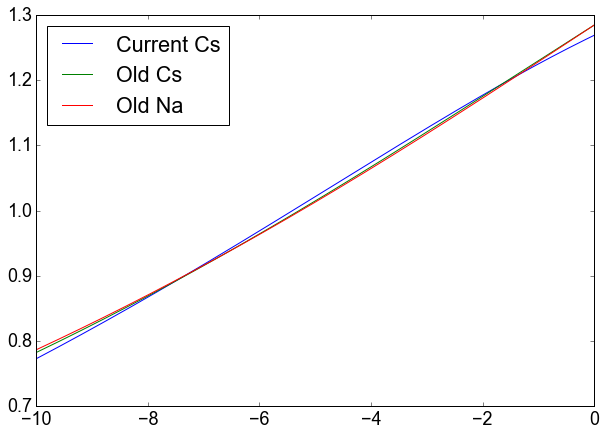

In [93]:
def f_s1_corr(x):
    return p2(x, *popt_ly)
plt.plot(x_plot, get_cs1(1, x_plot, f_s1_corr), label='Current Cs')

def f_s1_corr(x):
    return p2(x, *popt_cs)
plt.plot(x_plot, get_cs1(1, x_plot, f_s1_corr), label='Old Cs')

def f_s1_corr(x):
    return p2(x, *popt_na)
plt.plot(x_plot, get_cs1(1, x_plot, f_s1_corr), label='Old Na')
plt.legend(loc='best')

First, the photopeak is selected using loose by-eye diagonal cuts. This selection is used to perform rough position-dependent corrections in S1 and S2. By using an unbinned maximum likelihood fit, the charge yield and light yield are determined, so that g1 and g2 can be computed. These values are then used to refine the photopeak selection (+- x sigma), after which the S1 and S2 corrections are recomputed. We repeat the analysis with different photopeak selection and quote the systematic uncertainties from the change the value obtained.

Zoiets.

In [104]:
def exp_decay(x, a0, tau):
    return a0 * np.exp( - x / tau)

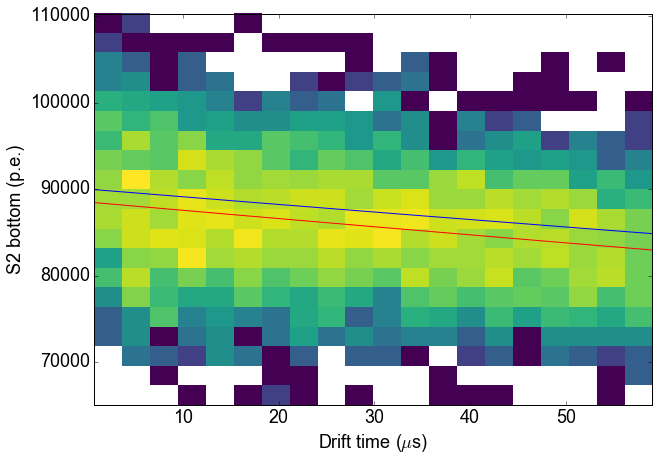

In [110]:
plt.hist2d(pp['drift_time'], pp['s2_bot'], bins=20, norm=LogNorm())
plt.xlabel('Drift time ($\mu$s)')
plt.ylabel('S2 bottom (p.e.)')
x_plot = np.linspace(0, 60, 250)
p0 = [90e3, 1e3]
plt.plot(x_plot, exp_decay(x_plot, *p0))
# plt.savefig('plots/cs_lifetime_pretty_good.png')
popt_life, pcov_life = scipy.optimize.curve_fit(exp_decay, pp['drift_time'], pp['s2_bot'], p0)
plt.plot(x_plot, exp_decay(x_plot, *popt_life), color='red')
plt.show()

In [108]:
popt_life

array([ 88507.31809672,    910.36714589])

In [109]:
np.sqrt(np.diag(pcov_life))

array([ 207.65129846,   61.13000836])

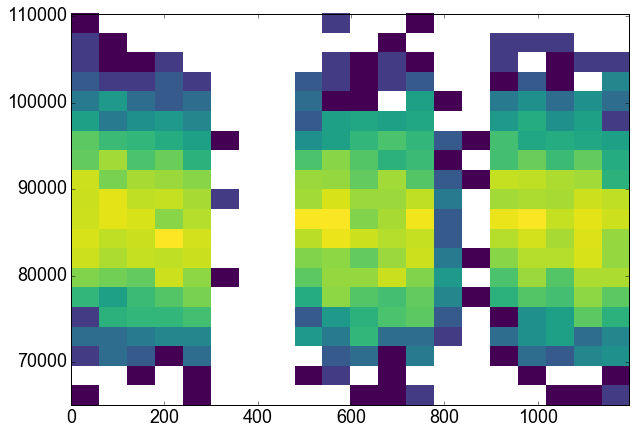

In [102]:
plt.hist2d(pp['t'], pp['s2_bot'], norm=LogNorm(), bins=20)
plt.show()

In [111]:
cuts.history(x.d)

,selection_desc,n_before,n_after,n_removed,fraction_passed,cumulative_fraction_left
0,Finite s1,125339,115063,10276,0.918014,0.918014
1,largest_other_s1 below 10,115063,104879,10184,0.911492,0.836763
2,largest_other_s2 below 500,104879,82729,22150,0.788804,0.660042
3,s1 above 50,82729,82382,347,0.995806,0.657273
4,s2 above 1000,82382,81909,473,0.994258,0.653500
5,AFT_Upper,81909,77724,4185,0.948907,0.620110
6,AFT_Lower,77724,73161,4563,0.941292,0.583705
7,"drift_time in [0, 60)",73161,73149,12,0.999836,0.583609
8,Upper bound S2 width,73149,59971,13178,0.819847,0.478470
9,Lower bound S2 width,59971,46796,13175,0.780310,0.373355


## Other crap

### S1 rise time study

For the S1 rise time, it seems the best parameter is the 10-20% point. This does not really seem to help a lot for misclassified small S2s though. Have to look into low-e data to see if this is a good idea.

In [ ]:
d['rise_10_20'] = d['s1_time_from_midpoint_20p'] - d['s1_time_from_midpoint_10p']
d['rise_10_30'] = d['s1_time_from_midpoint_30p'] - d['s1_time_from_midpoint_10p']
d['rise_10_40'] = d['s1_time_from_midpoint_40p'] - d['s1_time_from_midpoint_10p']
d['rise_10_50'] = d['s1_center_time'] - d['s1_time_from_midpoint_10p']

In [ ]:
plt.hist(d['rise_10_20'] - np.median(d['rise_10_20']), bins=100, histtype='step', range=(-20, 20), normed=True)
plt.hist(d['rise_10_30'] - np.median(d['rise_10_30']), bins=100, histtype='step', range=(-20, 20), normed=True)
plt.hist(d['rise_10_40'] - np.median(d['rise_10_40']), bins=100, histtype='step', range=(-20, 20), normed=True)

plt.show()

In [ ]:
plt.scatter(d['s1'], d['s1_time_from_midpoint_20p'] - d['s1_time_from_midpoint_10p'], label='Time 10% - 20%', 
            color='green')
plt.scatter(d['s1'], d['s1_time_from_midpoint_30p'] - d['s1_time_from_midpoint_10p'], label='Time 10% - 30%', 
            color='red')
plt.scatter(d['s1'], d['s1_time_from_midpoint_40p'] - d['s1_time_from_midpoint_10p'], label='Time 10% - 40%', 
            color='orange')
plt.scatter(d['s1'], 0 - d['s1_time_from_midpoint_10p'], label='Time 10% - 50%')

plt.xlim(0, 2000)
plt.ylim(0, 25)
plt.legend()
plt.xlabel('S1')
plt.ylabel('$\Delta$t (ns)')

In [ ]:
plt.scatter(d['s1'], d['rise_10_20'])
plt.axhline(10)
plt.xscale('log')
plt.yscale('log')